# 1. 데이터 불러오기
California 집 값 예측에 사용할 데이터입니다. 이 데이터는 [Kaggle](https://www.kaggle.com/harrywang/housing) 에서 얻을 수 있습니다. 이 데이터는 *핸즈 온 머신러닝*에서 사용한 데이터입니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터를 로드하여 DataFrame에 저장합니다.
housing_data = pd.read_csv('./input/housing.csv')

In [3]:
# 데이터를 살펴봅니디.
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


모델링의 목표는 median_house_value를 예측하는 것입니다. 

In [4]:
housing_data.describe()
# 25번째 백분위수(제1사분위수), 중간값, 75번째 백분위수(제3사분위수)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


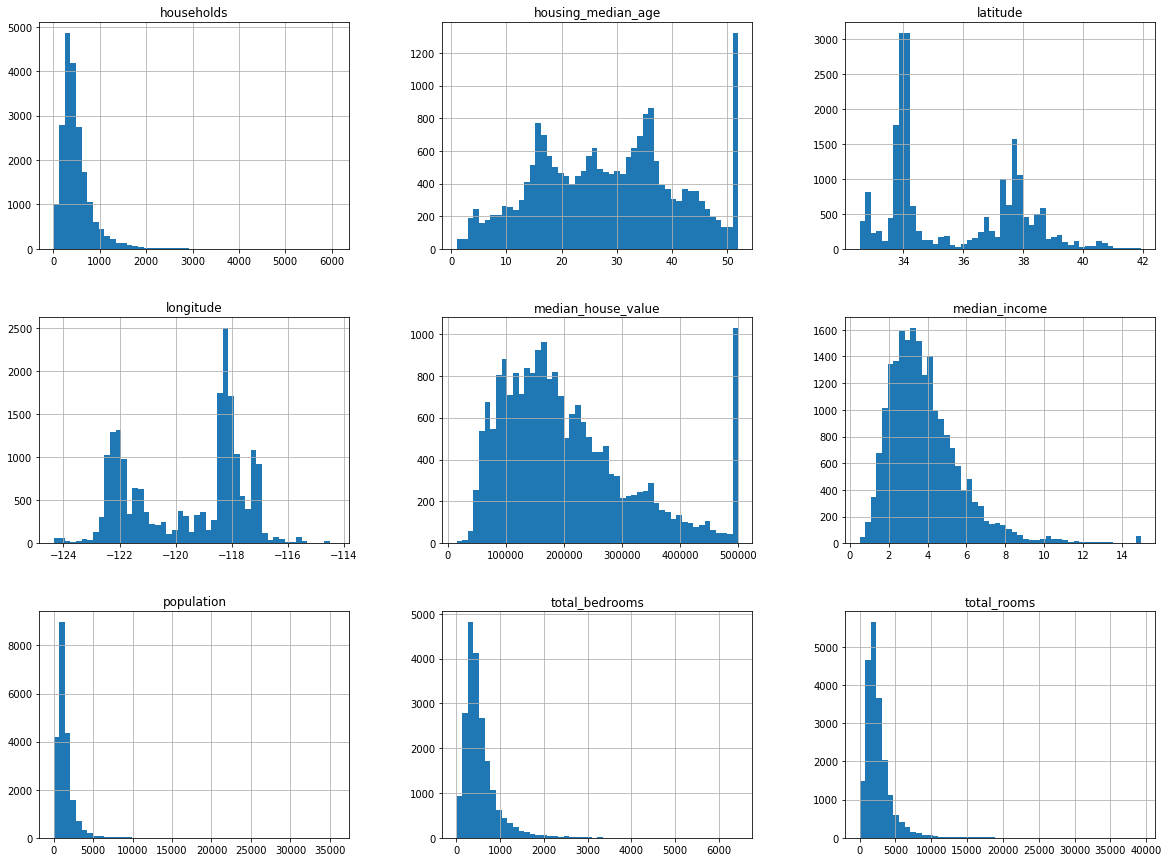

In [5]:
# 간단하게 데이터의 분포를 시각화합니다.
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

데이터를 제대로 살펴보기 전에, train set과 test set을 분리합니다. **데이터 스누핑**을 방지하기 위하여, test set을 train set과 명확하게 분리합니다. (데이터 스누핑 : 이미 모델에 노출된 test set을 이용하여 모델을 선택하여, 매우 낙관적인 추정이 되고 기대한 성능이 나오지 않는 것) 또한 test set은 전체 data set에서 중요한 특성의 카테고리를 잘 대표해야 합니다. 즉 median_income 특성이 집 값 예측에 중요한 특성이라면, 해당 특성의 카테고리가 test set에 골고루 분포하도록 해야 합니다.

In [6]:
# Median income에서 골고루 test set을 뽑기 위하여, median income을 1~5의 카테고리로 나눕니다.
housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0, inplace=True)

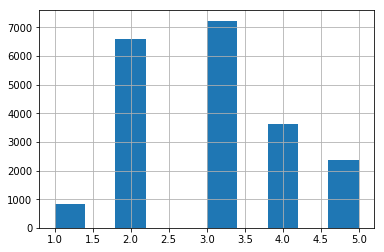

In [7]:
housing_data['income_cat'].hist()

Train set과 test set을 나눕니다. `StratifiedShuffleSplit`을 사용하면 특성의 카테고리 별 비율을 반영하여 data set을 나눌 수 있습니다.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_idx]
    strat_test_set = housing_data.loc[test_idx]

In [9]:
# Data set에서 income category의 비율
housing_data['income_cat'].value_counts() / len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [10]:
# Train set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [11]:
# Test set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [12]:
for _set in ([strat_train_set, strat_test_set]):
    _set.drop('income_cat', axis=1, inplace=True)

# 2. 데이터 탐색(EDA)
데이터 탐색과 시각화(Exploratory data analysis)입니다. 훈련 세트가 매우 크면 조작을 간단하고 빠르게 하기 위해 탐색을 위한 세트를 별도로 샘플링할 수 있습니다.

In [13]:
eda_train_set = strat_train_set.copy()

### Plotting

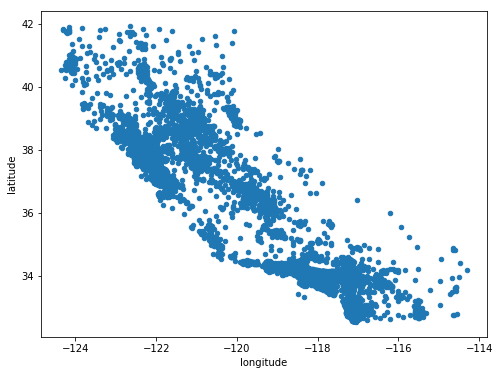

In [14]:
# 지리 정보(위도, 경도)가 있으므로 산점도 데이터 시각화를 합니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10, )

Scatter의 형태는 캘리포니아를 잘 나타내지만, 특별한 패턴을 찾기는 힘듭니다.

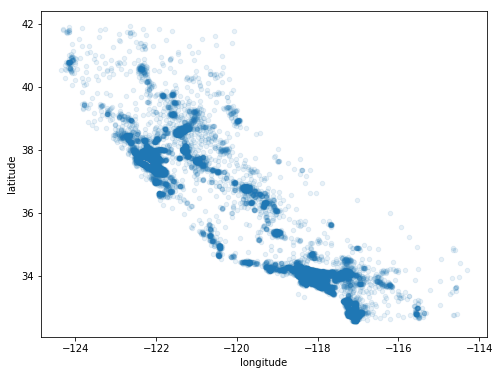

In [15]:
# 밀집된 지역을 나타냅니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10,  alpha=0.1)

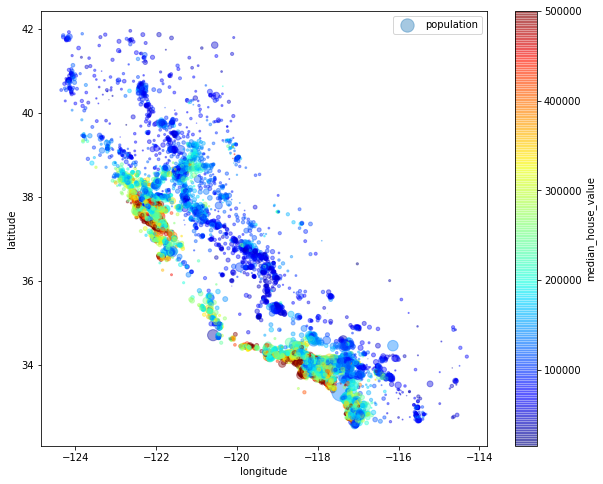

In [16]:
# 인구수는 scatter의 반지름 크기로 나타내고(s), 집 값은 scatter의 색깔을 나타낸다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(10, 8), fontsize=10, alpha=0.4,
                   s=eda_train_set['population']/100, label='population', c='median_house_value',
                   cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

주택 가격은 위치(바다와 가까운 곳일 수록 높다)와 인구 밀도에 관련이 있다고 볼 수 있습니다.

### 상관관계
**상관관계(피어슨의 r)**를 조사합니다.

In [17]:
corr_matrix = eda_train_set.corr()

> 상관관계를 수치로 살펴보겠습니다.

In [18]:
# 중간 주택 가격과 다른 특성 사이의 상관관계를 살펴본다.
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

median_income이 올라갈때 median_house_value이 올라가는 경향이 있습니다. 위도(latitude)가 올라갈 때 즉 북쪽으로 갈 때 집 값은 감소하는 경향을 보이고 있습니다.

> 상관관계를 시각화 해보겠습니다.

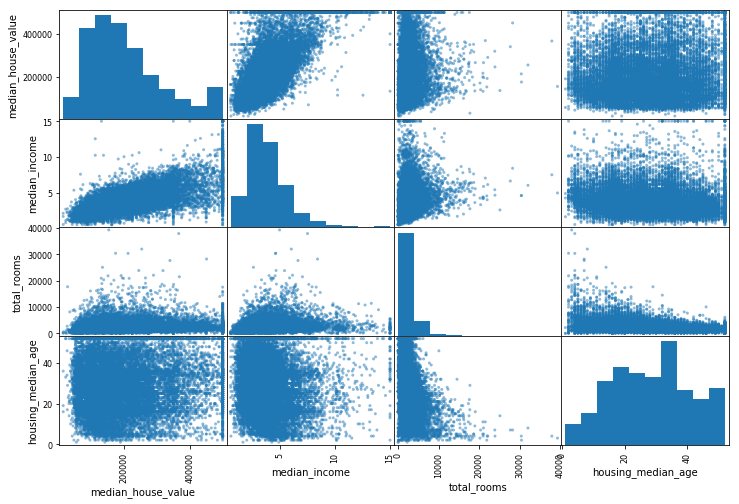

In [19]:
from pandas.plotting import scatter_matrix

attrs = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(eda_train_set[attrs], figsize=(12, 8))
plt.show()

예측에 가장 유용할 것 같은 median_income만 따로 확대해 봅니다.

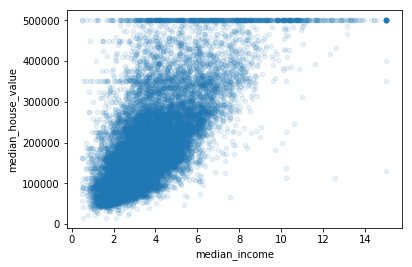

In [20]:
eda_train_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

알 수 있는 것
 - 상관관계가 매우 강합니다. 위쪽으로 향하는 경향이 있으며, 포인트들이 널리 퍼져 있지 않습니다.
 - 500,000은 가격 제한 값이라서 수평선이 생성되는 것이 문제가 없지만, 450,000 / 350,000 / 280,000 에도 수평선이 존재합니다. 이러한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋습니다.

> 특성들을 조합하고, 조합한 특성의 상관관계를 살펴봅니다.

개별 특성에 대한 탐색 뿐 만이 아니라, **특성의 조합을 시도**해봅니다. 이것을 통하여, 특성 자체만으로는 의미가 없었지만 조합을 통하여 의미가 있도록 할 수 있습니다.
- 한 가구당 방 개수 (방 개수 / 가구 수)
- 방의 개수 대비 침대의 개수 (침대 수 / 방 개수)
- 한 가구당 인원 수 (인구 수 / 가구 수)

In [21]:
eda_train_set['room_per_household'] = eda_train_set['total_rooms'] / eda_train_set['households']
eda_train_set['bedrooms_per_room'] = eda_train_set['total_bedrooms'] / eda_train_set['total_rooms']
eda_train_set['population_per_household'] = eda_train_set['population'] / eda_train_set['households']

In [22]:
corr_matrix = eda_train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

bedrooms_per_room은 total_bedrooms이나 total_rooms 보다 상관관계가 더 높습니다. (당연히, 더 큰 집이 비쌉니다.)

이 탐색 단계는 완벽하지 않습니다. 우선 처음에 얻은 통찰을 이용하여 프로토타입을 빠르게 생성하고 결과를 분석하여 더 많은 통찰을 얻은 후에, 이 탐색 단계로 돌아와서 결과를 바탕으로 데이터 탐색을 또 진행합니다. 이 과정을 빠르게 반복하는 것이 필요합니다.

# 3. 데이터 준비 (가공 및 정제)

In [23]:
train_x = strat_train_set.drop('median_house_value', axis=1)
train_y = strat_train_set['median_house_value'].copy()
test_x = strat_test_set.drop('median_house_value', axis=1)
test_y = strat_test_set['median_house_value'].copy()

> **누락된 값에 대한 처리 방법**
 - 해당 구역을 제거합니다. (해당하는 데이터만 제거)
 - 전체 특성을 삭제합니다. (해당하는 특성 자체를 사용하지 않음)
 - 어떤 값으로 채웁니다. (0, 평균, 중간값 등)

In [24]:
# 누락된 값을 확인합니다.
for col in train_x.columns:
    print(col, sum(train_x[col].isnull()))

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 158
population 0
households 0
median_income 0
ocean_proximity 0


`Imputer` 클래스는 누락된 값을 손쉽게 다루도록 해줍니다. 누락된 값을 중간값(median)으로 대체하겠습니다.

In [25]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [26]:
# Numeric data를 가지고 와서 imputer에 fitting 합니다.
num_train = train_x._get_numeric_data()
imputer.fit(num_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [27]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [28]:
train_x_num = imputer.transform(num_train)
train_x_num = pd.DataFrame(train_x_num, columns=num_train.columns, index=train_x.index.values)

In [29]:
train_x_num.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214


Test set도 train set과 동일하게, imputer를 사용합니다. 단! **train set에서의 스무딩값(여기서는 median)을 사용하여 test set을 스무딩한다**는 것에 주의해야 합니다.

In [30]:
test_x_num = pd.DataFrame(imputer.transform(test_x._get_numeric_data()), 
                          columns=test_x._get_numeric_data().columns,
                          index=test_x.index.values)

In [31]:
test_x_num.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111


> **텍스트 feauture 또는 Categorical feature(범주형 특성) 다루기**
- 텍스트는 feature는 sklearn 모델에서 학습할 수 없습니다. 정수 또는 실수의 형태로 바꾸어야 합니다. `LabelBinarizer`를 사용할 수 있습니다.
- Pandas의 `get_dummy`를 간단하게 사용할 수 있습니다.

In [32]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
ocean_proximity = encoder.fit_transform(strat_train_set['ocean_proximity']) 

In [33]:
# Sklearn의 labelbinarizer를 사용한 결과입니다.
ocean_proximity

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [34]:
# Pandas를 사용하겠습니다.
train_ocean_proximity_dummies = pd.get_dummies(strat_train_set['ocean_proximity'])
train_ocean_proximity_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


In [35]:
# Numerical data와 one hot vector data를 합칩니다.
train_x = pd.concat([train_x_num, train_ocean_proximity_dummies], axis=1)

In [36]:
train_x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,1,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,1,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,0,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,1,0,0,0,0


In [37]:
# Test set도 동일하게 처리합니다.
test_ocean_proximity_dummies = pd.get_dummies(strat_test_set['ocean_proximity'])
test_ocean_proximity_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,1,0,0,0,0
10970,1,0,0,0,0
20351,1,0,0,0,0
6568,0,1,0,0,0
13285,0,1,0,0,0


In [38]:
test_x = pd.concat([test_x_num, test_ocean_proximity_dummies], axis=1)
test_x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,1,0,0,0,0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,1,0,0,0,0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,1,0,0,0,0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,0,1,0,0,0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,0,1,0,0,0


In [39]:
# Feature의 리스트를 따로 저장합니다.
feature_list = train_x.columns.values

> **Feature scaling** : 머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않습니다.
 - **min-max scaling**
  - 데이터에서 최소값을 뺀 후 최대값과 최솟값의 차이로 나눕니다. `MinMaxSclaer`
 - **표준화(standardization)**
  - 데이터에서 평균을 뺀 후 표준편차를 나누어 결과 분포의 분산이 1이 되도록 합니다. `StandardScaler`

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [41]:
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

위의 과정을 자동화하기 위하여 `Pipeline`을 사용할 수 있습니다. 이것은 나중에 배우도록 하겠습니다.

# 4. 모델 선택과 훈련

간단하게 선형회귀모형을 이용하여 훈련시켜보겠습니다.

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

학습이 끝났습니다. Train set에 있는 몇 개 샘플에 대하여 적용해보고 결과를 보도록 하겠습니다.

In [44]:
x_samples = train_x[:5]
y_samples = train_y[:5]

In [45]:
print('Predictions: ', lin_reg.predict(x_samples))

Predictions:  [211574.39523833 321345.10513719 210947.519838    61921.01197838
 192362.32961119]


In [46]:
print('Labels: ', list(y_samples))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


결과가 좋아보이지 않습니다. 회귀모형의 성능 평가 지표중의 하나인 **RMSE**를 사용하여 모델의 성능을 살펴보겠습니다.

In [47]:
from sklearn.metrics import mean_squared_error
predictions = lin_reg.predict(train_x)
lin_mse = mean_squared_error(train_y, predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

69050.98178244587


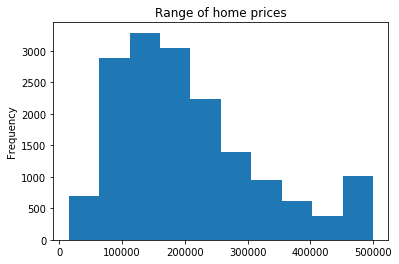

In [48]:
train_y.plot(kind='hist', title='Range of home prices')

집 값의 분포와 비교해보면 RMSE는 좋은 값이 아닙니다.

> **교차 검증(Cross validation)**
- 여러 모델의 성능을 비교하여 모델을 평가하거나, 모델의 파라미터를 결정하기 위해 교차 검증을 사용합니다.
- 학습 셋을 더 작은 학습 셋과 검증 셋으로 나누어, 작은 학습 셋에서 모델을 학습하고 검증 셋에서 모델을 검증합니다.

In [49]:
from sklearn.model_selection import cross_val_score

### Linear regression의 cross validation scores

In [50]:
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
lin_rmse_cv_scores = np.sqrt(-lin_scores)

In [51]:
# Cross validation score를 확인하기 위한 함수를 구현합니다.
def display_scores(scores):
    print('Scores', scores)
    print('Mean', scores.mean())
    print('Std deviation', scores.std())

In [52]:
display_scores(lin_rmse_cv_scores)

Scores [67461.52867859 67339.08986435 68373.32777565 74647.49979917
 68322.20051059 71682.06005523 65361.44957868 68585.90047389
 72482.62025423 68148.25656692]
Mean 69240.39335573053
Std deviation 2659.926605638619


성능을 비교하기 위하여 결정트리 모델의 cross validation scores를 사용합니다.

### Tree model의 cross validaton scores

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
tree_rmse_cv_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_cv_scores)

Scores [67783.44475045 66080.47686484 72643.75398489 69227.63752471
 69191.20261279 75281.20667084 64427.73204895 70604.4019466
 70241.65092602 68871.53460274]
Mean 69435.30419328161
Std deviation 2931.988104237168


선형 회귀 모형과 비교하여 오히려 모델 성능 지표(RMSE의 값)는 떨어졌습니다.

### Random forest model의 cross validation scores

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_scores = cross_val_score(rf_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
rf_rmse_cv_scores = np.sqrt(-rf_scores)

# 검증 셋에 대한 RMSE 값입니다.
display_scores(rf_rmse_cv_scores)

/Users/kakao/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Scores [50037.05337159 48540.49307123 50622.54292172 52869.6852628
 51544.9485124  56443.05086885 51263.96492907 54071.08740659
 54401.10021676 51469.98110508]
Mean 52126.39076660987
Std deviation 2216.764933118806


랜덤 포레스트 모델이 선형 회귀 모델과 비교했을때 모델 성능 지표가 더 높게 나왔습니다. 

In [55]:
rf_reg.fit(train_x, train_y)
pred = rf_reg.predict(train_x)

# 학습 셋에 대한 RMSE 값입니다.
np.sqrt(mean_squared_error(train_y, pred))

22173.849057334744

하지만 학습 셋에 대한 RMSE의 값이 검증 셋에 대한 RMSE 보다 많이 낮습니다. 그 이유는 Random forest 모델이 **과대적합(overfitting)** 되었기 때문입니다. 과대적합을 피하기 위해서는 다음과 같은 방법이 있습니다.
 - 모델을 간단히 한다.
 - 제한을 한다 즉 규제(Regularization)를 한다.
 - 더 많은 훈련 데이터를 모은다.
 
모델을 선택하기 전에, 여러 종류의 머신러닝 알고리즘으로 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 <U>다양한 모델들을 시도</U>해야 합니다. 가능성 있는 2~5개의 모델을 선정하는것이 목적입니다.

# 5. 모델 세부 튜닝
가능성 있는 모델들을 추렸다고 가정합시다. 이 모델들을 세부 튜닝해야 합니다. 튜닝 방법에는 대표적으로 아래와 같은 방법들이 있습니다.
 - 그리드 탐색
 - 랜덤 선택
 - 앙상블 방법

### 그리드 탐색
 - sklearn의 `GridSearchCV`

In [56]:
from sklearn.model_selection import GridSearchCV

# 탐색할 parameter set : 전체 훈련 횟수는 18 * 5 = 90 입니다.
params = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

# 모델
forest_reg = RandomForestRegressor()

# 그리드 탐색
grid_search = GridSearchCV(forest_reg, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [57]:
# 가장 좋은 파라미터
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [58]:
# 가장 좋은 Tree model
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [59]:
# 각 파라미터에 대한 평가 점수
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

64865.479199151996 {'max_features': 2, 'n_estimators': 3}
55490.21089930166 {'max_features': 2, 'n_estimators': 10}
52917.63250800273 {'max_features': 2, 'n_estimators': 30}
61394.91180621938 {'max_features': 4, 'n_estimators': 3}
53625.5442395828 {'max_features': 4, 'n_estimators': 10}
50624.5952811309 {'max_features': 4, 'n_estimators': 30}
59612.98577005922 {'max_features': 6, 'n_estimators': 3}
52347.93441965575 {'max_features': 6, 'n_estimators': 10}
50505.3382943074 {'max_features': 6, 'n_estimators': 30}
59371.44022528554 {'max_features': 8, 'n_estimators': 3}
52398.68395527503 {'max_features': 8, 'n_estimators': 10}
50062.399389697646 {'max_features': 8, 'n_estimators': 30}
62789.35272700491 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54131.255221103485 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58984.94344999353 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52968.905021111335 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

앞의 예에서 봤던 RMSE는 평균 52247.025765264174 이었지만 파라미터 튜닝 결과 얻은 RMSE는 평균 50057.411415517876 입니다. 8, 30은 각 파라미터의 최대값이었기 때문에 모델의 성능을 더 향상시킬 수 있습니다.

### 랜덤 탐색
sklearn의 `RandomizedSearchCV`를 사용합니다. 후보 중에서 파라미터를 랜덤하게 선택하여 모델을 생성합니다.

### 모델 분석

In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.14540569e-01, 1.04042941e-01, 4.88527703e-02, 3.07812297e-02,
       2.71165464e-02, 3.89795174e-02, 2.54716645e-02, 4.42881626e-01,
       1.47747030e-02, 1.43889433e-01, 3.27331822e-05, 2.64102478e-03,
       5.99524188e-03])

In [63]:
sorted(zip(feature_importances, feature_list), reverse=True)

[(0.4428816262337401, 'median_income'),
 (0.14388943270375637, 'INLAND'),
 (0.11454056893250208, 'longitude'),
 (0.1040429409837915, 'latitude'),
 (0.04885277025434244, 'housing_median_age'),
 (0.03897951737881501, 'population'),
 (0.030781229743878643, 'total_rooms'),
 (0.027116546426895736, 'total_bedrooms'),
 (0.025471664534531126, 'households'),
 (0.014774702962788055, '<1H OCEAN'),
 (0.005995241880585107, 'NEAR OCEAN'),
 (0.0026410247821426892, 'NEAR BAY'),
 (3.2733182231267626e-05, 'ISLAND')]

# 6. 테스트 셋에 의한 모델 평가 

In [64]:
final_model = grid_search.best_estimator_

final_pred = final_model.predict(test_x)
final_rmse = np.sqrt(mean_squared_error(test_y, final_pred))

final_rmse

47648.695663694474

테스트 셋을 평가할 때, 하이퍼파라미터 튜닝을 많이 했으면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 경우가 많습니다. 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에(검증 데이터에 과대적합 될 가능성이 높습니다.) 새로운 데이터셋에서는 잘 작동하지 않을 수 있다는 것을 명심해야 합니다.